In [12]:
import os, pdb, sys, json, math
from lumina.genetic.metrics.ts_pnl import calculate_ful_ts_ret
from lumina.genetic.signal.method import *
from lumina.genetic.strategy.method import *
from lumina.genetic.process import *
from lumina.genetic.metrics.evaluate import FactorEvaluate
from ultron.factor.genetic.geneticist.operators import *
import ultron.factor.empyrical as empyrical

from dotenv import load_dotenv
load_dotenv()

from kdutils.common import *
from kdutils.macro2 import *

In [2]:
name = 'train'
method = 'aicso0'
task_id = '200036'
instruments = "ims"

In [3]:
factors_data = fetch_temp_data(
            method=method,
            task_id=task_id,
            instruments=instruments,
            datasets=name if isinstance(name, list) else [name])

factors_data = factors_data.drop_duplicates(
    subset=['trade_time', 'code']).reset_index(drop=True)
factors_data.head()

./records/aicso0/ims/basic/train_data.feather


,trade_time,code,fz002_10_15_0,fz002_10_15_1,fz002_5_10_0,fz002_5_10_1,gd002_10_15_0,gd002_10_15_1,gd002_5_10_0,gd002_5_10_1,...,tf022_5_10_0,tf022_5_10_1,close,high,low,open,value,volume,openint,vwap
0,2022-07-25 09:30:00,IM,0.000005,0.000012,1.510336e-07,0.000011,0.514307,0.535732,0.638363,0.594229,...,6960.738199,6965.166142,6974.2,6974.2,6974.2,6974.2,78111040.0,56.0,17477.0,6974.200000
1,2022-07-25 09:31:00,IM,0.000004,0.000014,-5.022059e-07,0.000019,0.519601,0.490171,0.577894,0.474407,...,6962.646048,6965.797137,6973.8,6994.8,6964.4,6971.8,848911040.0,608.0,17333.0,6981.176316
2,2022-07-25 09:32:00,IM,0.000004,0.000023,5.013559e-06,0.000050,0.505921,0.437287,0.506818,0.366650,...,6965.278947,6967.786373,6982.8,6995.2,6969.6,6973.8,597671840.0,428.0,17268.0,6982.147664
3,2022-07-25 09:33:00,IM,0.000006,0.000033,1.808164e-05,0.000077,0.482672,0.387361,0.415001,0.283643,...,6970.107860,6972.851800,6989.8,6989.8,6981.6,6982.8,391195160.0,280.0,17213.0,6985.627857
4,2022-07-25 09:34:00,IM,0.000008,0.000042,3.322211e-05,0.000094,0.453396,0.340788,0.309016,0.219035,...,6976.463962,6976.334521,6993.0,6993.0,6982.6,6989.6,447271480.0,320.0,17123.0,6988.616875


In [4]:
returns_data = fetch_temp_data(
            method=method,
            task_id=task_id,
            instruments=instruments,
            datasets=name if isinstance(name, list) else [name],
            category='returns')

returns_data = returns_data.drop_duplicates(
    subset=['trade_time', 'code']).reset_index(drop=True)
returns_data.head()

./records/aicso0/ims/basic/train_returns.feather


,trade_time,code,nxt1_ret_1h,nxt1_ret_2h,nxt1_ret_3h,time_weight,equal_weight
0,2022-07-22 09:30:00,IM,0.001999,0.003928,0.003025,0.002813,0.002984
1,2022-07-22 09:31:00,IM,0.001929,0.001026,0.000801,0.001440,0.001252
2,2022-07-22 09:32:00,IM,-0.000903,-0.001129,-0.000504,-0.000912,-0.000845
3,2022-07-22 09:33:00,IM,-0.000225,0.000400,-0.000063,0.000010,0.000037
4,2022-07-22 09:34:00,IM,0.000625,0.000162,-0.000448,0.000292,0.000113


In [5]:
total_data = factors_data.merge(returns_data, on=['trade_time','code'])
total_data.head()

,trade_time,code,fz002_10_15_0,fz002_10_15_1,fz002_5_10_0,fz002_5_10_1,gd002_10_15_0,gd002_10_15_1,gd002_5_10_0,gd002_5_10_1,...,open,value,volume,openint,vwap,nxt1_ret_1h,nxt1_ret_2h,nxt1_ret_3h,time_weight,equal_weight
0,2022-07-25 09:30:00,IM,0.000005,0.000012,1.510336e-07,0.000011,0.514307,0.535732,0.638363,0.594229,...,6974.2,78111040.0,56.0,17477.0,6974.200000,0.000139,0.000637,0.001065,0.000460,0.000614
1,2022-07-25 09:31:00,IM,0.000004,0.000014,-5.022059e-07,0.000019,0.519601,0.490171,0.577894,0.474407,...,6971.8,848911040.0,608.0,17333.0,6981.176316,0.000498,0.000926,0.002696,0.001007,0.001374
2,2022-07-25 09:32:00,IM,0.000004,0.000023,5.013559e-06,0.000050,0.505921,0.437287,0.506818,0.366650,...,6973.8,597671840.0,428.0,17268.0,6982.147664,0.000428,0.002198,0.002777,0.001409,0.001801
3,2022-07-25 09:33:00,IM,0.000006,0.000033,1.808164e-05,0.000077,0.482672,0.387361,0.415001,0.283643,...,6982.8,391195160.0,280.0,17213.0,6985.627857,0.001770,0.002349,0.002794,0.002134,0.002304
4,2022-07-25 09:34:00,IM,0.000008,0.000042,3.322211e-05,0.000094,0.453396,0.340788,0.309016,0.219035,...,6989.6,447271480.0,320.0,17123.0,6988.616875,0.000579,0.001023,0.000546,0.000721,0.000716


In [6]:
total_data = total_data.set_index('trade_time')

In [67]:
express1 = "MDPO(8,'tv018_10_15_0')"

In [68]:
from ultron.factor.genetic.geneticist.operators import calc_factor
factor_data = calc_factor(expression=express1,
                              total_data=total_data,
                              key='code',
                              indexs=[])

In [69]:
factor_data = factor_data.replace([np.inf, -np.inf], np.nan)
factor_data['transformed'] = np.where(
        np.abs(factor_data.transformed.values) > 0.000001,
        factor_data.transformed.values, np.nan)
factor_data = factor_data.loc[factor_data.index.unique()[1:]]
factor_data.head()

,transformed,code
trade_time,,
2022-07-25 09:31:00,0.493841,IM
2022-07-25 09:32:00,0.291815,IM
2022-07-25 09:33:00,0.170497,IM
2022-07-25 09:34:00,0.086206,IM
2022-07-25 09:35:00,0.051383,IM


In [70]:
factors_data1 = factor_data.reset_index()
total_data1 = factors_data1.merge(returns_data, on=['trade_time',
                                                        'code']).dropna()

In [71]:
factors_data21 = total_data1.copy()
factors_data21.head()

,trade_time,transformed,code,nxt1_ret_1h,nxt1_ret_2h,nxt1_ret_3h,time_weight,equal_weight
0,2022-07-25 09:31:00,0.493841,IM,0.000498,0.000926,0.002696,0.001007,0.001374
1,2022-07-25 09:32:00,0.291815,IM,0.000428,0.002198,0.002777,0.001409,0.001801
2,2022-07-25 09:33:00,0.170497,IM,0.001770,0.002349,0.002794,0.002134,0.002304
3,2022-07-25 09:34:00,0.086206,IM,0.000579,0.001023,0.000546,0.000721,0.000716
4,2022-07-25 09:35:00,0.051383,IM,0.000445,-0.000033,0.000962,0.000372,0.000458


In [72]:
#factors_data21['transformed'] = 0 - factors_data21['transformed']
fe1 = FactorEvaluate(
        factor_data=factors_data21,
        factor_name='transformed',
        ret_name='nxt1_ret_1h',
        roll_win=30,  # 因子放缩窗口，自定义
        fee=0.0000005,
        scale_method='roll_zscore') 


In [73]:
fe1.run()

{'total_ret': -0.03842733137591725,
 'avg_ret': -3.0820445409118694e-07,
 'max_dd': -0.11621787211128753,
 'calmar': -0.3306490703866969,
 'sharpe': -0.014667830784996167,
 'turnover': 0.07794975598935927,
 'win_rate': 0.5023532578929291,
 'profit_ratio': 0.996244811711917,
 'ic_mean': -0.07534413111954208,
 'ic_std': 0.19078042035325488,
 'ic_ir': -0.39492591000707816}

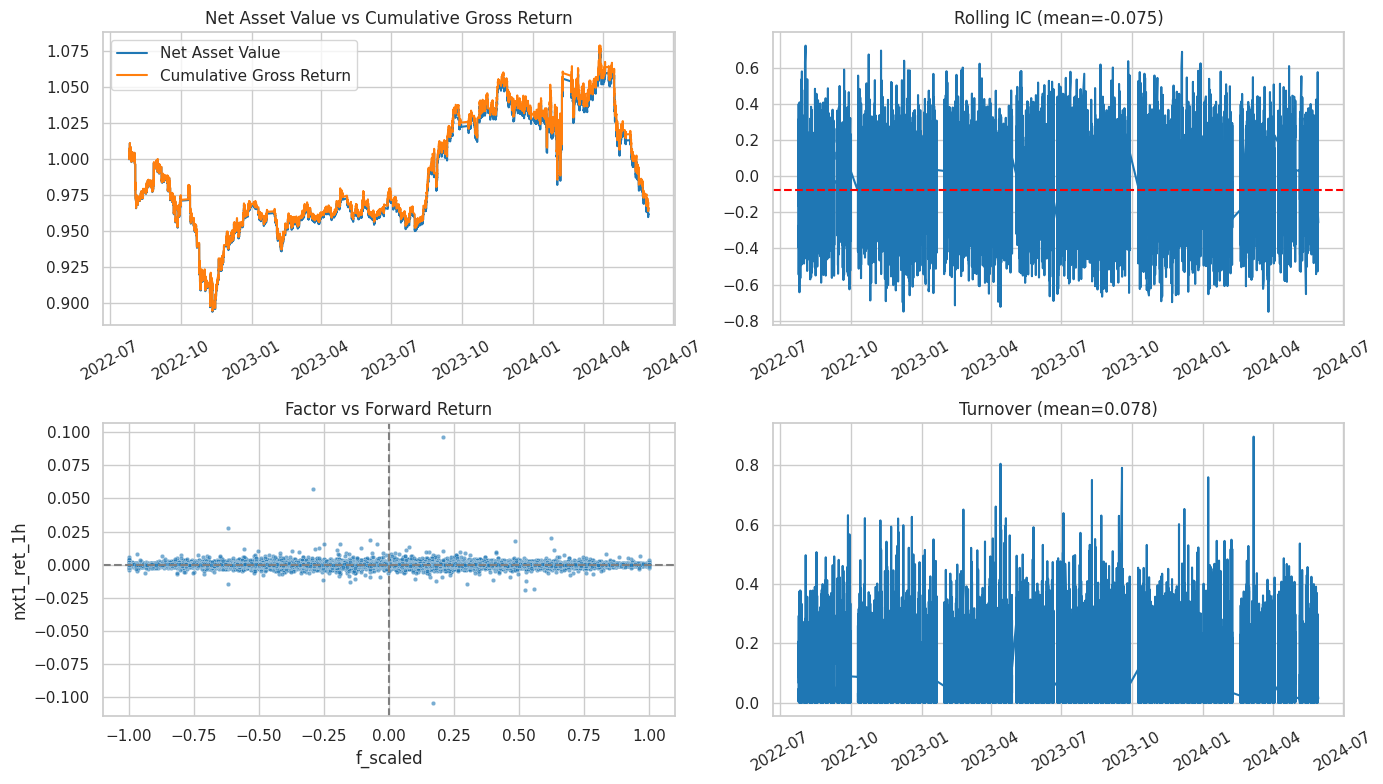

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. 净值 + 累计毛收益
axes[0, 0].plot(fe1.factor_data['nav'], label='Net Asset Value')
cum_gross = (1 + fe1.factor_data['gross_ret']).cumprod()
axes[0, 0].plot(cum_gross, label='Cumulative Gross Return')
axes[0, 0].set_title('Net Asset Value vs Cumulative Gross Return')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=30)


# 2. 滚动 IC
axes[0, 1].plot(fe1.factor_data['ic'])
axes[0, 1].axhline(fe1.factor_data['ic'].mean(), color='red', ls='--')
axes[0, 1].set_title(f'Rolling IC (mean={fe1.factor_data["ic"].mean():.3f})')
axes[0, 1].tick_params(axis='x', rotation=30)

sns.scatterplot(x='f_scaled', y=fe1.ret_name,
                        data=fe1.factor_data, ax=axes[1, 0], s=10, alpha=0.6)
axes[1, 0].axhline(0, ls='--', c='grey')
axes[1, 0].axvline(0, ls='--', c='grey')
axes[1, 0].set_title('Factor vs Forward Return')


axes[1, 1].plot(fe1.factor_data['turnover'])
axes[1, 1].set_title(f'Turnover (mean={fe1.factor_data["turnover"].mean():.3f})')
axes[1, 1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()